# Corona Virus - Covid-19 Analysis and Forecast
- Inspired on the work of [Devakumar kp](https://www.kaggle.com/imdevskp/covid-19-analysis-viz-prediction-comparisons)
- by Marcelo Rovai
- 03 March 2020

## Main Libraries and setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import plotly
import plotly.graph_objs as go
import folium


In [2]:
import itertools
from scipy import stats
import statsmodels.api as sm
from scipy.special import boxcox, inv_boxcox
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from prophet import Prophet

In [3]:
import warnings
warnings.simplefilter('ignore')

In [4]:

pd.set_option('display.float_format', lambda x: '%.f' % x)
sns.set(context='paper', style='ticks', palette='inferno')
sns.mpl.rc("figure", figsize=(10, 6))
mpl.rcParams['figure.dpi']= 150
plotly.offline.init_notebook_mode(connected=True)

pd.options.display.float_format = '{:,}'.format

## Load Data

COVID-19 Complete Dataset (Updated every 24hrs) - Kaggle depository <br>
Number of Confirmed, Death and Recovered cases every day across the globe
- Day level information on covid-19 affected cases
- [COVID-19 Complete Dataset (Updated every 24hrs)](https://www.kaggle.com/imdevskp/corona-virus-report#covid_19_clean_complete.csv)

**Context**

A new coronavirus designated 2019-nCoV was first identified in Wuhan, the capital of China's Hubei province, after people developed pneumonia without a clear cause and for which existing vaccines or treatments were not effective. The virus has shown evidence of human-to-human transmission, and its transmission rate (rate of infection) appeared to escalate in mid-January 2020, with several countries across Europe, North America, and the Asia Pacific reporting cases.

As of 30 January 2020, approximately 8,243 cases have been confirmed, including in every province of China. The first confirmed death from the coronavirus infection occurred on 9 January and since then 170 deaths have been confirmed.

- Data from [OMS Coronavirus disease (COVID-2019) daily situation reports](https://www.who.int/emergencies/diseases/novel-coronavirus-2019/situation-reports)

**Column Description**
    - Province/State - Province or state of the observation (Could be empty when missing)
    - Country/Region - Country of observation
    - Lat - Latitude Geo - Referenciation of Province or Country
    - Long - Longitude Geo- Referenciation of Province or Country
    - Date - Date of the observation in MM/DD/YYYY
    - Confirmed - Cumulative number of confirmed cases till that date
    - Deaths - Cumulative number of of deaths till that date
    - Recovered - Cumulative number of recovered cases till that date


In [5]:
#ls ../data

In [6]:
df = pd.read_csv('covid_19_clean_complete.csv' )
df.shape

(5822, 8)

In [7]:
df.head(5)


Province/State  Country/Region     Lat     Long     Date  Confirmed  Deaths  \
0          Anhui  Mainland China 31.8257 117.2264  1/22/20          1       0   
1        Beijing  Mainland China 40.1824 116.4142  1/22/20         14       0   
2      Chongqing  Mainland China 30.0572  107.874  1/22/20          6       0   
3         Fujian  Mainland China 26.0789 117.9874  1/22/20          1       0   
4          Gansu  Mainland China 36.0611 103.8343  1/22/20          0       0   

   Recovered  
0          0  
1          0  
2          0  
3          0  
4          0

In [8]:
df.tail(5)

Province/State Country/Region     Lat      Long    Date  Confirmed  \
5817  Placer County, CA             US 39.0916 -120.8039  3/2/20          1   
5818      San Mateo, CA             US  37.563 -122.3255  3/2/20          1   
5819       Sarasota, FL             US 27.3364  -82.5307  3/2/20          1   
5820  Sonoma County, CA             US  38.578 -122.9888  3/2/20          1   
5821       Umatilla, OR             US  45.775 -118.7606  3/2/20          1   

      Deaths  Recovered  
5817       0          0  
5818       0          0  
5819       0          0  
5820       0          0  
5821       0          0

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Province/State  3075 non-null   object 
 1   Country/Region  5822 non-null   object 
 2   Lat             5822 non-null   float64
 3   Long            5822 non-null   float64
 4   Date            5822 non-null   object 
 5   Confirmed       5822 non-null   int64  
 6   Deaths          5822 non-null   int64  
 7   Recovered       5822 non-null   int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 364.0+ KB


In [10]:
df['Date'] = pd.to_datetime(df['Date'])
df.info()

# got a warning here that was ignored when cell 3 was not implemented

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Province/State  3075 non-null   object        
 1   Country/Region  5822 non-null   object        
 2   Lat             5822 non-null   float64       
 3   Long            5822 non-null   float64       
 4   Date            5822 non-null   datetime64[ns]
 5   Confirmed       5822 non-null   int64         
 6   Deaths          5822 non-null   int64         
 7   Recovered       5822 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 364.0+ KB


In [11]:
df['Country/Region'].value_counts()[:10]

Country/Region
Mainland China    1271
US                1189
Australia          287
Canada             164
Denmark             41
Lithuania           41
Iceland             41
Belarus             41
San Marino          41
Netherlands         41
Name: count, dtype: int64

In [12]:
df['Province/State'].value_counts()[:10]

Province/State
Cook County, IL                      82
Anhui                                41
Boston, MA                           41
Omaha, NE (From Diamond Princess)    41
San Antonio, TX                      41
San Diego County, CA                 41
Diamond Princess cruise ship         41
Madison, WI                          41
San Benito, CA                       41
South Australia                      41
Name: count, dtype: int64

In [13]:
df['Country/Region'] = df['Country/Region'].replace('Mainland China', 'China')
df['Country/Region'] = df['Country/Region'].replace('Others', 'Ship Diam Princess')
print(df[:100])


   Province/State   Country/Region     Lat     Long       Date  Confirmed  \
0           Anhui            China 31.8257 117.2264 2020-01-22          1   
1         Beijing            China 40.1824 116.4142 2020-01-22         14   
2       Chongqing            China 30.0572  107.874 2020-01-22          6   
3          Fujian            China 26.0789 117.9874 2020-01-22          1   
4           Gansu            China 36.0611 103.8343 2020-01-22          0   
..            ...              ...     ...      ...        ...        ...   
95            NaN           Brazil -14.235 -51.9253 2020-01-22          0   
96            NaN          Georgia 42.3154  43.3569 2020-01-22          0   
97            NaN           Greece 39.0742  21.8243 2020-01-22          0   
98            NaN  North Macedonia 41.6086  21.7453 2020-01-22          0   
99            NaN           Norway  60.472   8.4689 2020-01-22          0   

    Deaths  Recovered  
0        0          0  
1        0          0  
2  

In [14]:
df.isnull().sum()

Province/State    2747
Country/Region       0
Lat                  0
Long                 0
Date                 0
Confirmed            0
Deaths               0
Recovered            0
dtype: int64

In [15]:
df[['Province/State']] = df[['Province/State']].fillna('NA')
df[:100]


Province/State   Country/Region     Lat     Long       Date  Confirmed  \
0           Anhui            China 31.8257 117.2264 2020-01-22          1   
1         Beijing            China 40.1824 116.4142 2020-01-22         14   
2       Chongqing            China 30.0572  107.874 2020-01-22          6   
3          Fujian            China 26.0789 117.9874 2020-01-22          1   
4           Gansu            China 36.0611 103.8343 2020-01-22          0   
..            ...              ...     ...      ...        ...        ...   
95             NA           Brazil -14.235 -51.9253 2020-01-22          0   
96             NA          Georgia 42.3154  43.3569 2020-01-22          0   
97             NA           Greece 39.0742  21.8243 2020-01-22          0   
98             NA  North Macedonia 41.6086  21.7453 2020-01-22          0   
99             NA           Norway  60.472   8.4689 2020-01-22          0   

    Deaths  Recovered  
0        0          0  
1        0          0  
2        0          0  
3        0          0  
4        0          0  
..     ...        ...  
95       0          0  
96       0          0  
97       0          0  
98       0          0  
99       0          0  

[100 rows x 8 columns]

In [16]:
df['Deaths/Confirmed'] = round((df.Deaths/df.Confirmed)*100, 1)

In [17]:
df['Deaths/Confirmed'] = df['Deaths/Confirmed'].fillna(0)

In [54]:
df.head(15)


Province/State Country/Region                Lat     Long       Date  \
0            Anhui          China            31.8257 117.2264 2020-01-22   
1          Beijing          China            40.1824 116.4142 2020-01-22   
2        Chongqing          China            30.0572  107.874 2020-01-22   
3           Fujian          China            26.0789 117.9874 2020-01-22   
4            Gansu          China            36.0611 103.8343 2020-01-22   
5        Guangdong          China            23.3417 113.4244 2020-01-22   
6          Guangxi          China            23.8298 108.7881 2020-01-22   
7          Guizhou          China            26.8154 106.8748 2020-01-22   
8           Hainan          China            19.1959 109.7453 2020-01-22   
9            Hebei          China            38.0428 114.5149 2020-01-22   
10    Heilongjiang          China             47.862 127.7615 2020-01-22   
11           Henan          China 33.882020000000004  113.614 2020-01-22   
12           Hubei          China            30.9756 112.2707 2020-01-22   
13           Hunan          China            27.6104 111.7088 2020-01-22   
14  Inner Mongolia          China            44.0935 113.9448 2020-01-22   

    Confirmed  Deaths  Recovered  Deaths/Confirmed  
0           1       0          0               0.0  
1          14       0          0               0.0  
2           6       0          0               0.0  
3           1       0          0               0.0  
4           0       0          0               0.0  
5          26       0          0               0.0  
6           2       0          0               0.0  
7           1       0          0               0.0  
8           4       0          0               0.0  
9           1       0          0               0.0  
10          0       0          0               0.0  
11          5       0          0               0.0  
12        444      17         28               3.8  
13          4       0          0               0.0  
14          0       0          0               0.0

## WorldWide Consolidated Timeline

In [56]:
df_ww = df.groupby(['Date'])[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()
df_ww['Deaths/Confirmed'] = round((df_ww.Deaths/df_ww.Confirmed)*100, 1)
df_ww = df_ww.sort_values(by='Confirmed', ascending=False)
df_ww.head()

Date  Confirmed  Deaths  Recovered  Deaths/Confirmed
40 2020-03-02      90313    3085      45604               3.4
39 2020-03-01      88371    2996      42716               3.4
38 2020-02-29      86013    2941      39782               3.4
37 2020-02-28      84122    2872      36711               3.4
36 2020-02-27      82756    2814      33277               3.4

In [20]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_ww.Date, y=df_ww.Confirmed, mode='lines', name='Confirmed'))
fig.add_trace(go.Scatter(x=df_ww.Date, y=df_ww.Deaths, mode='lines', name='Deaths'))

#fig.add_trace(go.Line(x=df_ww.Date, y=df_ww.Confirmed, name='Confirmed'))
#fig.add_trace(go.Line(x=df_ww.Date, y=df_ww.Deaths, name='Deaths'))
fig.update_layout(
    title="        Covid-19 WorldWide Cases",
    xaxis_title="Day",
    yaxis_title="# Cases",
    )
fig.show()



## WW by Country

In [21]:
df_country = df.groupby(['Country/Region', 'Province/State'])[['Confirmed', 'Deaths', 'Recovered']].max().reset_index()
df_country['Deaths/Confirmed'] = round((df_country.Deaths/df_country.Confirmed)*100, 1)
df_country = df_country.sort_values(by='Confirmed', ascending=False)
df_country.head()

Country/Region Province/State  Confirmed  Deaths  Recovered  \
34           China          Hubei      67103    2803      33934   
103    South Korea             NA       4335      28         30   
73           Italy             NA       2036      52        149   
69            Iran             NA       1501      66        291   
27           China      Guangdong       1350       7       1059   

     Deaths/Confirmed  
34                4.2  
103               0.6  
73                2.6  
69                4.4  
27                0.5

In [22]:
df_country['Country/Region'].value_counts()

Country/Region
China                   31
US                      28
Australia                7
Canada                   4
Azerbaijan               1
                        ..
Vietnam                  1
Netherlands              1
Austria                  1
United Arab Emirates     1
Afghanistan              1
Name: count, Length: 75, dtype: int64

In [23]:
df_country_consol = df_country.groupby(['Country/Region'])[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()
df_country_consol['Deaths/Confirmed'] = round((df_country_consol.Deaths/df_country_consol.Confirmed)*100, 1)
df_country_consol = df_country_consol.sort_values(by='Confirmed', ascending=False)
df_country_consol.head()

Country/Region  Confirmed  Deaths  Recovered  Deaths/Confirmed
13               China      80026    2912      44810               3.6
64         South Korea       4335      28         30               0.6
34               Italy       2036      52        149               2.6
30                Iran       1501      66        291               4.4
62  Ship Diam Princess        705       6         10               0.9

In [24]:
df_country_consol[df_country_consol.Deaths >0]

Country/Region  Confirmed  Deaths  Recovered  Deaths/Confirmed
13               China      80026    2912      44810               3.6
64         South Korea       4335      28         30               0.6
34               Italy       2036      52        149               2.6
30                Iran       1501      66        291               4.4
62  Ship Diam Princess        705       6         10               0.9
35               Japan        274       6         32               2.2
22              France        191       3         12               1.6
72                  US        119       6          7               5.0
26           Hong Kong        100       2         36               2.0
70            Thailand         43       1         31               2.3
69              Taiwan         41       1         12               2.4
4            Australia         38       1         11               2.6
54         Philippines          3       1          1              33.3

In [25]:
m = folium.Map(location=[0, 20], tiles='cartodbpositron',
               min_zoom=1, max_zoom=4, zoom_start=2)

for i in range(0, len(df)):
    folium.Circle(
        location=[df.iloc[i]['Lat'], df.iloc[i]['Long']],
        color='crimson', 
        tooltip =   '<li><bold>Country : '+str(df.iloc[i]['Country/Region'])+
                    '<li><bold>Province : '+str(df.iloc[i]['Province/State'])+
                    '<li><bold>Confirmed : '+str(df.iloc[i]['Confirmed'])+
                    '<li><bold>Deaths : '+str(df.iloc[i]['Deaths'])+
                    '<li><bold>Recovered : '+str(df.iloc[i]['Recovered']),
        radius=int(df.iloc[i]['Confirmed'])).add_to(m)
m

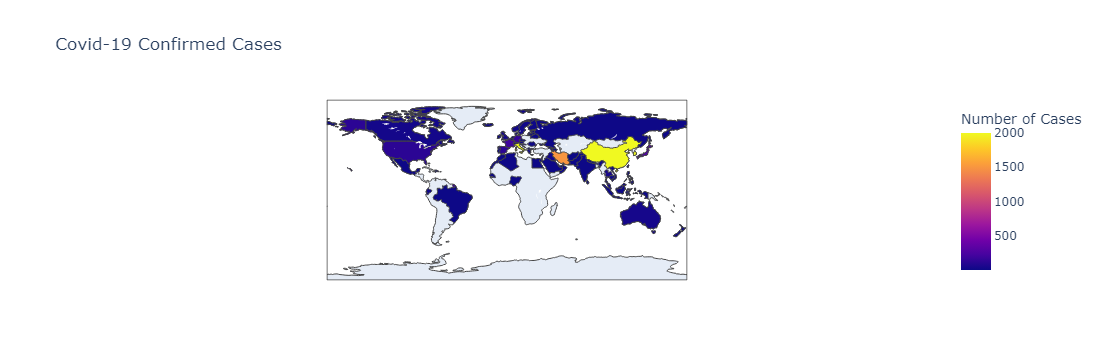

In [58]:
fig = go.Figure(data=go.Choropleth(
    locations=df_country_consol['Country/Region'],
    z = df_country_consol['Confirmed'].astype(float),
    zmin = 1, zmax = 2000,
    locationmode = 'country names',
    colorbar_title = "Number of Cases"
))

fig.update_layout(
    title_text = 'Covid-19 Confirmed Cases'
)

fig.show()

## China Case

In [27]:
df_china_full = df[df['Country/Region'] == 'China']

In [60]:
df_china = df_china_full.groupby(['Date'])[['Confirmed', 'Deaths', 'Recovered']].sum()
df_china['Deaths/Confirmed'] = round((df_china.Deaths/df_china.Confirmed)*100, 1)
df_china = df_china.reset_index()
df_china.head()



Date  Confirmed  Deaths  Recovered  Deaths/Confirmed
36 2020-02-27      78498    2744      32898               3.5
37 2020-02-28      78824    2788      36291               3.5
38 2020-02-29      79251    2835      39279               3.6
39 2020-03-01      79826    2870      42118               3.6
40 2020-03-02      80026    2912      44810               3.6

In [29]:
df_china.Confirmed.max()

80026

In [30]:
df_china.Deaths.max()

2912

In [31]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_ww.Date, y=df_ww.Confirmed, mode='lines', name='WorldWide Confirmed Cases'))
fig.add_trace(go.Scatter(x=df_china.Date, y=df_china.Confirmed, mode='lines', name='China Confirmed Cases'))
fig.add_trace(go.Scatter(x=df_ww.Date, y=df_ww.Deaths, mode='lines', name='WorldWide Deaths'))
fig.add_trace(go.Scatter(x=df_china.Date, y=df_china.Deaths, mode='lines', name='China Deaths'))


# fig.add_trace(go.Line(x=df_ww.Date, y=df_ww.Confirmed, name='WorldWide Confirmed Cases'))
# fig.add_trace(go.Line(x=df_china.Date, y=df_china.Confirmed, name='China Confirmed Cases'))
# fig.add_trace(go.Line(x=df_ww.Date, y=df_ww.Deaths, name='WorldWide Deaths'))
# fig.add_trace(go.Line(x=df_china.Date, y=df_china.Deaths, name='China Deaths'))

fig.update_layout(
    title="        Covid-19 Cases - China vs WW",
    xaxis_title="Day",
    yaxis_title="# Cases"
    )
fig.show()

In [32]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_ww.Date, y=df_ww['Deaths/Confirmed'], mode='lines', name='WorldWide'))
fig.add_trace(go.Scatter(x=df_china.Date, y=df_china['Deaths/Confirmed'], mode='lines', name='China'))

fig.update_layout(
    title="Covid-19 Deaths/Confirmed cases rate - China vs WW",
    xaxis_title="Day",
    yaxis_title="Percentage",
    )
fig.show()

### Where in China

In [33]:
df_china_prov = df_china_full.groupby(['Province/State'])[['Confirmed', 'Deaths', 'Recovered']].max()
df_china_prov = df_china_prov.sort_values(by='Confirmed', ascending=False)
df_china_prov = df_china_prov.reset_index()
df_china_prov.head(10)

Province/State  Confirmed  Deaths  Recovered
0          Hubei      67103    2803      33934
1      Guangdong       1350       7       1059
2          Henan       1272      22       1205
3       Zhejiang       1206       1       1069
4          Hunan       1018       4        887
5          Anhui        990       6        917
6        Jiangxi        935       1        850
7       Shandong        758       6        460
8        Jiangsu        631       0        543
9      Chongqing        576       6        469

In [34]:
print("Number of Confirmed Cases in China: {:,}".format(df_china_prov.Confirmed.sum()))
print("Number of Deaths in China: {:,}".format(df_china_prov.Deaths.sum()))

Number of Confirmed Cases in China: 80,026
Number of Deaths in China: 2,912


## Analysis per Country

In [35]:
def graph_data(df, country, value, di=0):
    df = df[di:]
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df['Date'], y=df[value], mode='lines', name=value))

    if value == 'Deaths/Confirmed':
        yaxis_title = "Percentage"
    else:
        yaxis_title = "# Cases"

    fig.update_layout(title="Covid-19 - " + country + " " + value + " Cases ",
                      xaxis_title="Day",
                      yaxis_title=yaxis_title)
    fig.show()

In [36]:
def country_analysis(df, country):
    df_country = df[df['Country/Region'] == country]
    df_country = df_country.groupby(['Date'])[['Confirmed', 'Deaths', 'Recovered']].sum()
    df_country['Deaths/Confirmed'] = round((df_country.Deaths/df_country.Confirmed)*100, 1)
    df_country['Deaths/Confirmed'] = df_country['Deaths/Confirmed'].fillna(0)
    df_country = df_country.reset_index()
    return df_country

### Italy

In [37]:
df_italy = country_analysis(df, 'Italy')
df_italy.sort_values(by='Confirmed', ascending=False)[:10]

Date  Confirmed  Deaths  Recovered  Deaths/Confirmed
40 2020-03-02       2036      52        149               2.6
39 2020-03-01       1694      34         83               2.0
38 2020-02-29       1128      29         46               2.6
37 2020-02-28        888      21         46               2.4
36 2020-02-27        655      17         45               2.6
35 2020-02-26        453      12          3               2.6
34 2020-02-25        322      10          1               3.1
33 2020-02-24        229       7          1               3.1
32 2020-02-23        155       3          2               1.9
31 2020-02-22         62       2          1               3.2

In [38]:
graph_data(df_italy, 'Italy', 'Confirmed', 30)
graph_data(df_italy, 'Italy', 'Deaths', 30)

### US

In [39]:
df_US = country_analysis(df, 'US')
df_US.sort_values(by='Confirmed', ascending=False)[:10]

Date  Confirmed  Deaths  Recovered  Deaths/Confirmed
40 2020-03-02        105       6          9               5.7
39 2020-03-01         76       1          7               1.3
38 2020-02-29         70       1          7               1.4
37 2020-02-28         62       0          7               0.0
36 2020-02-27         60       0          6               0.0
35 2020-02-26         59       0          6               0.0
34 2020-02-25         53       0          6               0.0
33 2020-02-24         53       0          5               0.0
30 2020-02-21         35       0          5               0.0
31 2020-02-22         35       0          5               0.0

In [40]:
graph_data(df_US, 'US', 'Confirmed')
graph_data(df_US, 'US', 'Deaths')

## Prophet

In [41]:
df_pf = df_china[['Date', 'Deaths']].copy()
df_pf.columns = ['ds', 'y']
df_pf.head(10)


ds    y
0 2020-01-22   17
1 2020-01-23   18
2 2020-01-24   26
3 2020-01-25   42
4 2020-01-26   56
5 2020-01-27   82
6 2020-01-28  131
7 2020-01-29  133
8 2020-01-30  171
9 2020-01-31  213

In [42]:
frequency = 'd'
prediction_size = 15
boxCoxApply = True

16:41:16 - cmdstanpy - INFO - Chain [1] start processing
16:41:16 - cmdstanpy - INFO - Chain [1] done processing


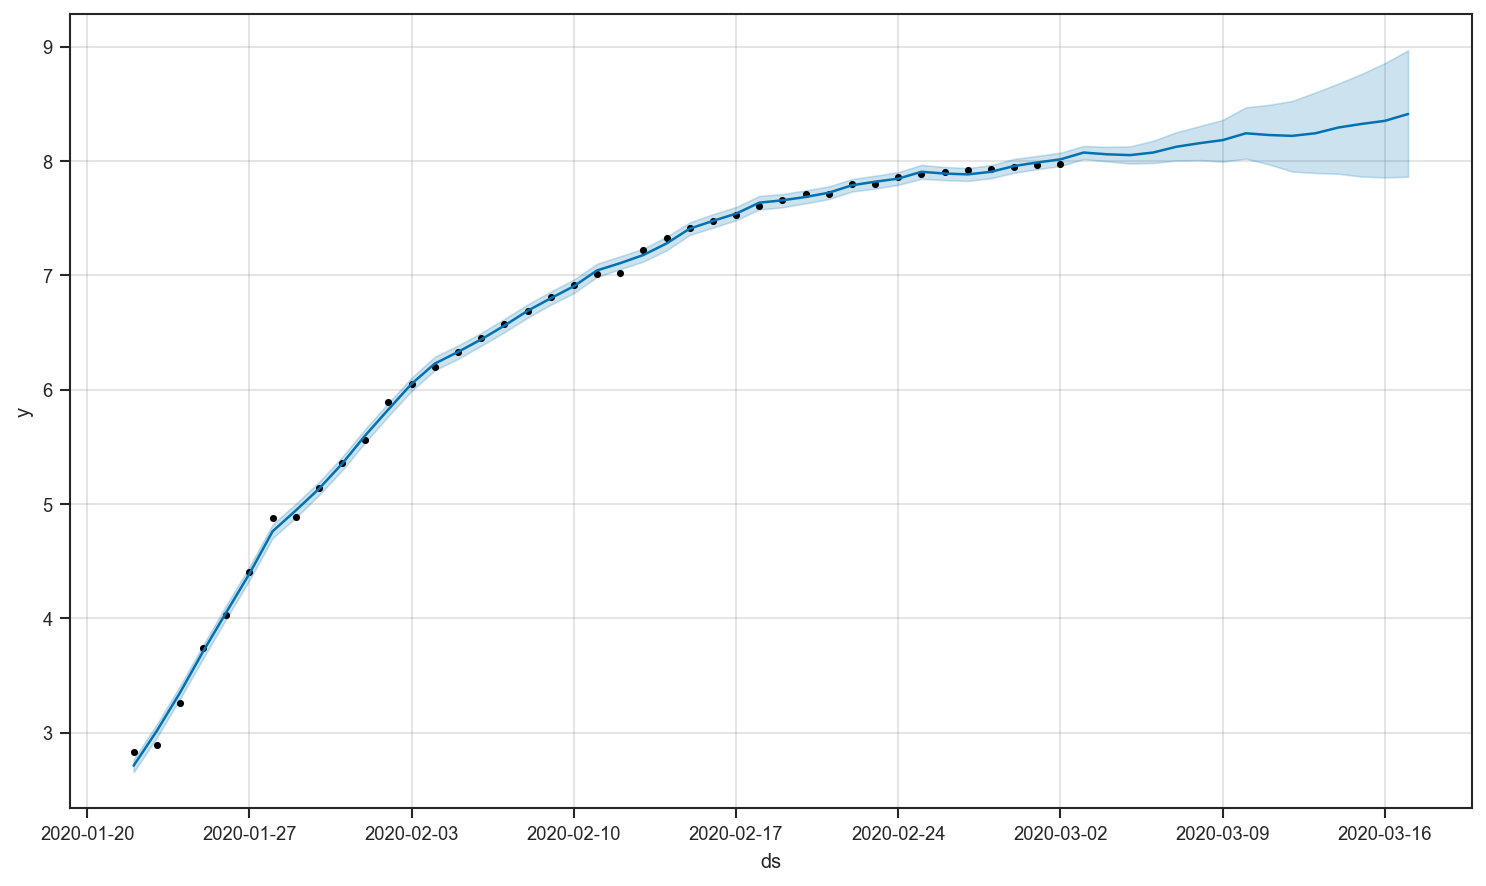

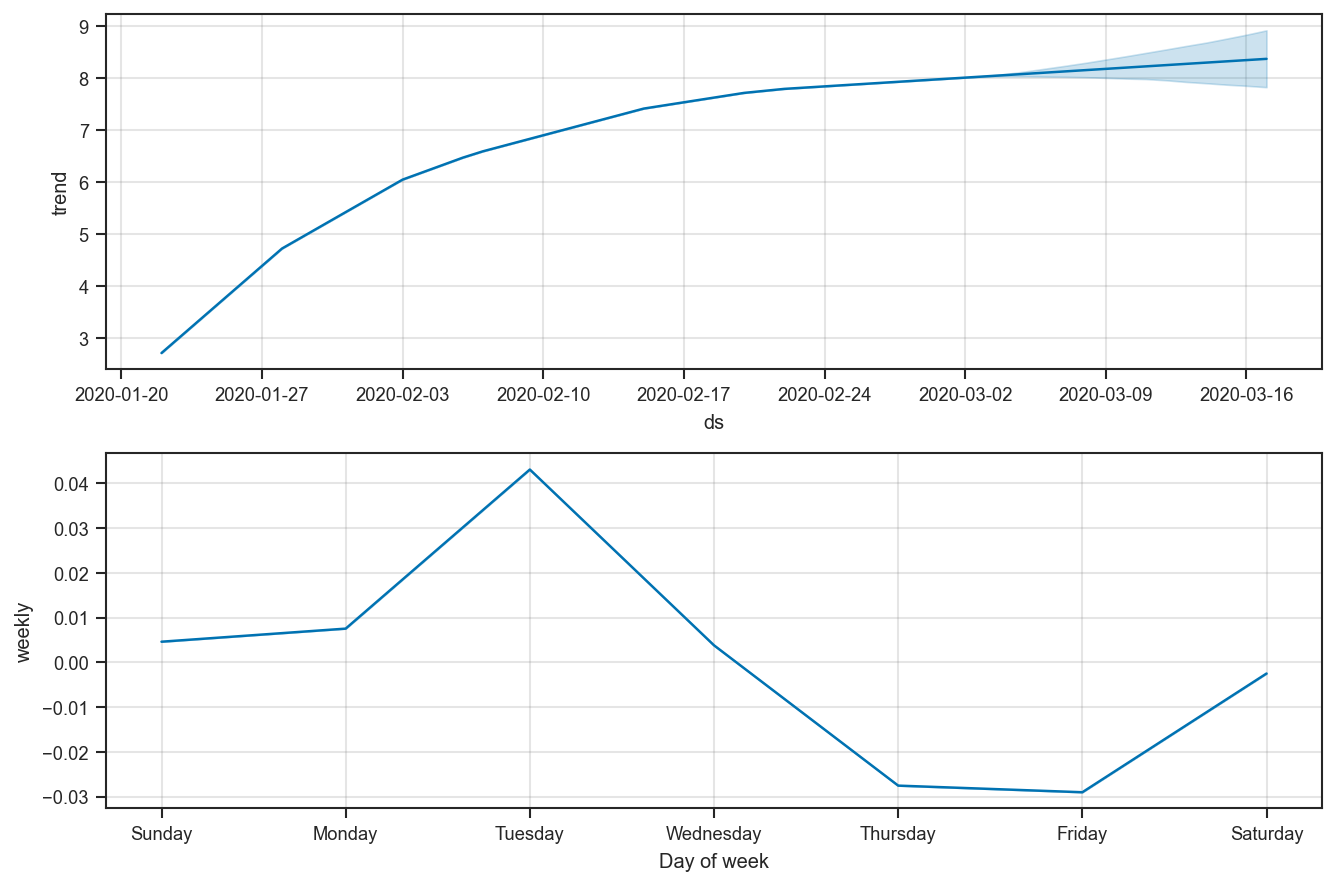

In [43]:
if boxCoxApply: 
    df_pf['y'] = boxcox(df_pf['y'], 0)
m = Prophet()
m.fit(df_pf)
future = m.make_future_dataframe(periods=prediction_size, freq=frequency)
forecast = m.predict(future)
m.plot(forecast);
m.plot_components(forecast);
if boxCoxApply:
    forecast[['yhat']] = inv_boxcox(forecast[['yhat']],0)
    df_pf[['y']] = inv_boxcox(df_pf[['y']],0)

In [44]:
df_china_fc = forecast[['ds','yhat']]
df_china_fc.columns = ['Date', 'Deaths']

In [45]:
df_china_fc.head()

Date             Deaths
0 2020-01-22 15.043598659623408
1 2020-01-23  20.38474305541392
2 2020-01-24  28.45977471262423
3 2020-01-25  40.86197956047874
4 2020-01-26  57.54065882195747

In [46]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_china.Date, y=df_china.Deaths, mode="lines", name='Confirmed Deadly Cases'))
fig.add_trace(go.Scatter(x=df_china_fc.Date, y=df_china_fc.Deaths, mode='lines', name='Deaths Forecast'))

fig.update_layout(
    title="Covid-19 - China Deadly Cases Forecast",
    xaxis_title="Day",
    yaxis_title="# Cases",
    )
fig.show()

### Forecast by Country

In [47]:
def graph_prediction(
        df,
        country,
        value,
        frequency='d',
        prediction_size=15,
        boxCoxApply=True,
):
    df = country_analysis(df, country)
    try:

        df_pf = df[['Date', value]].copy()
        df_pf.columns = ['ds', 'y']

        if boxCoxApply:
            df_pf['y'] = boxcox(df_pf['y'], 0)
        m = Prophet(daily_seasonality=True, yearly_seasonality=False)
        m.fit(df_pf)
        future = m.make_future_dataframe(periods=prediction_size,
                                         freq=frequency)
        forecast = m.predict(future)
        m.plot(forecast)
        m.plot_components(forecast)
        if boxCoxApply:
            forecast[['yhat']] = inv_boxcox(forecast[['yhat']], 0)
            df_pf[['y']] = inv_boxcox(df_pf[['y']], 0)

        df_fc = forecast[['ds', 'yhat']]
        df_fc.columns = ['Date', value]
    except:
        print("\n[INFO] Forecast Calculation not possible")
        df_fc = df

    fig = go.Figure()
    fig.add_trace(
        go.Scatter(x=df_fc['Date'], y=df_fc[value], mode='lines', name=value + ' Forecast'))
    fig.add_trace(go.Scatter(x=df['Date'], y=df[value], mode='lines', name=value))

    if value == 'Deaths/Confirmed':
        yaxis_title = "Percentage"
    else:
        yaxis_title = "# Cases"

    fig.update_layout(
        title="Covid-19 - " + country + " " + value + " Cases Prediction",
        xaxis_title="Day",
        yaxis_title=yaxis_title,
    )
    fig.show()

16:41:17 - cmdstanpy - INFO - Chain [1] start processing
16:41:17 - cmdstanpy - INFO - Chain [1] done processing


16:41:17 - cmdstanpy - INFO - Chain [1] start processing
16:41:17 - cmdstanpy - INFO - Chain [1] done processing


16:41:18 - cmdstanpy - INFO - Chain [1] start processing
16:41:18 - cmdstanpy - INFO - Chain [1] done processing


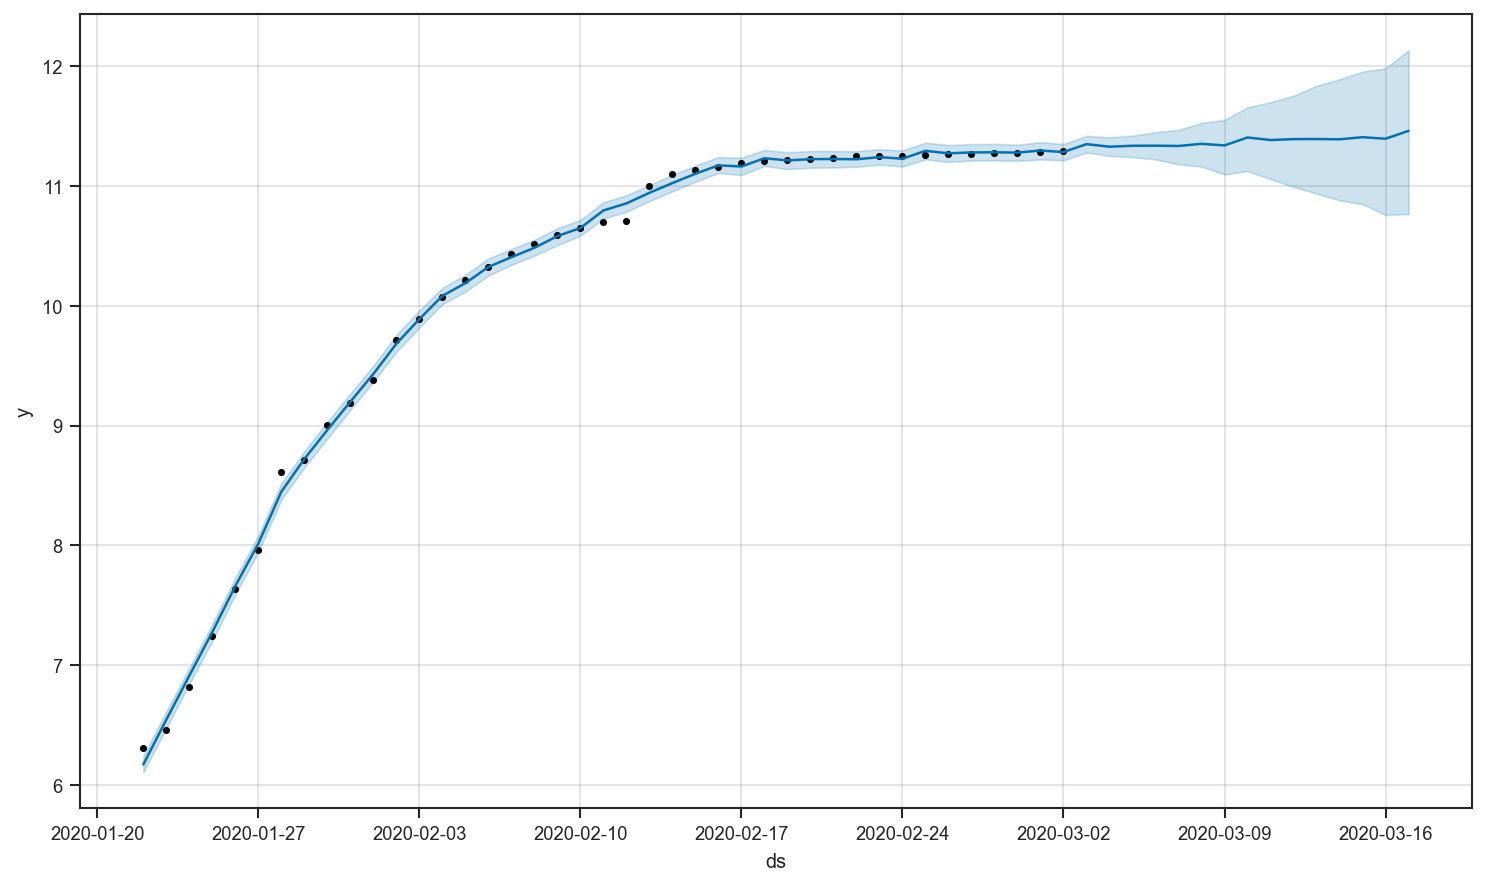

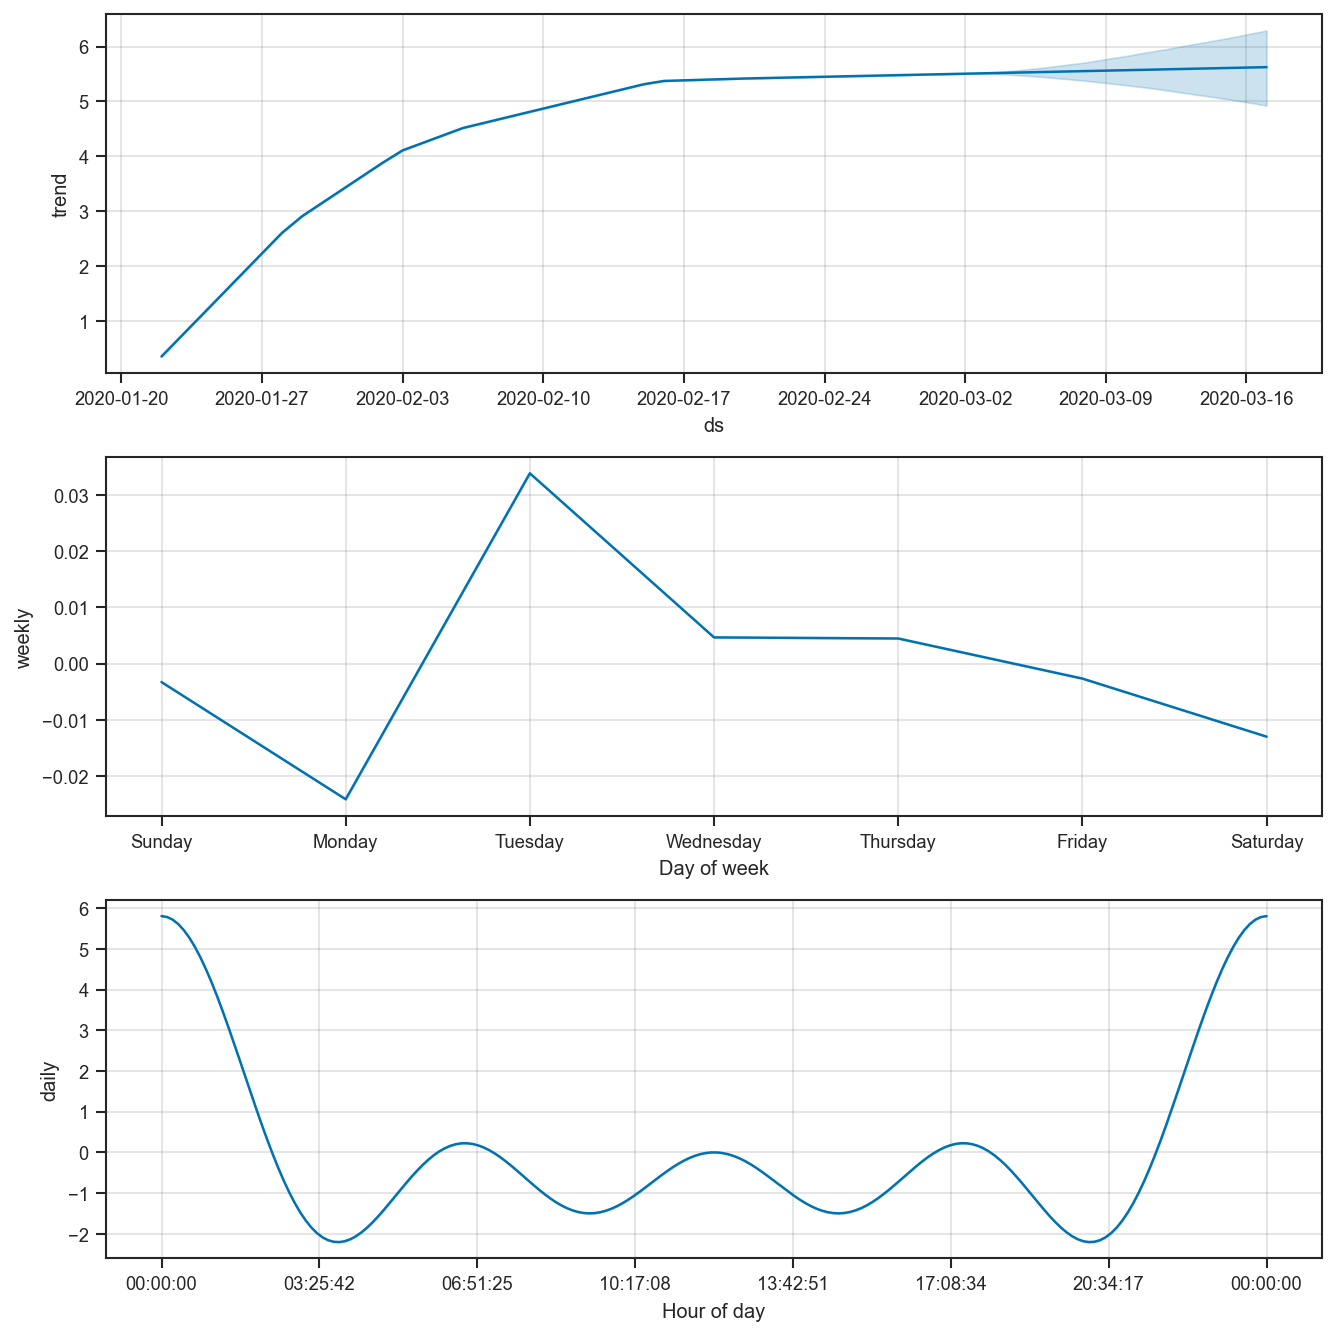

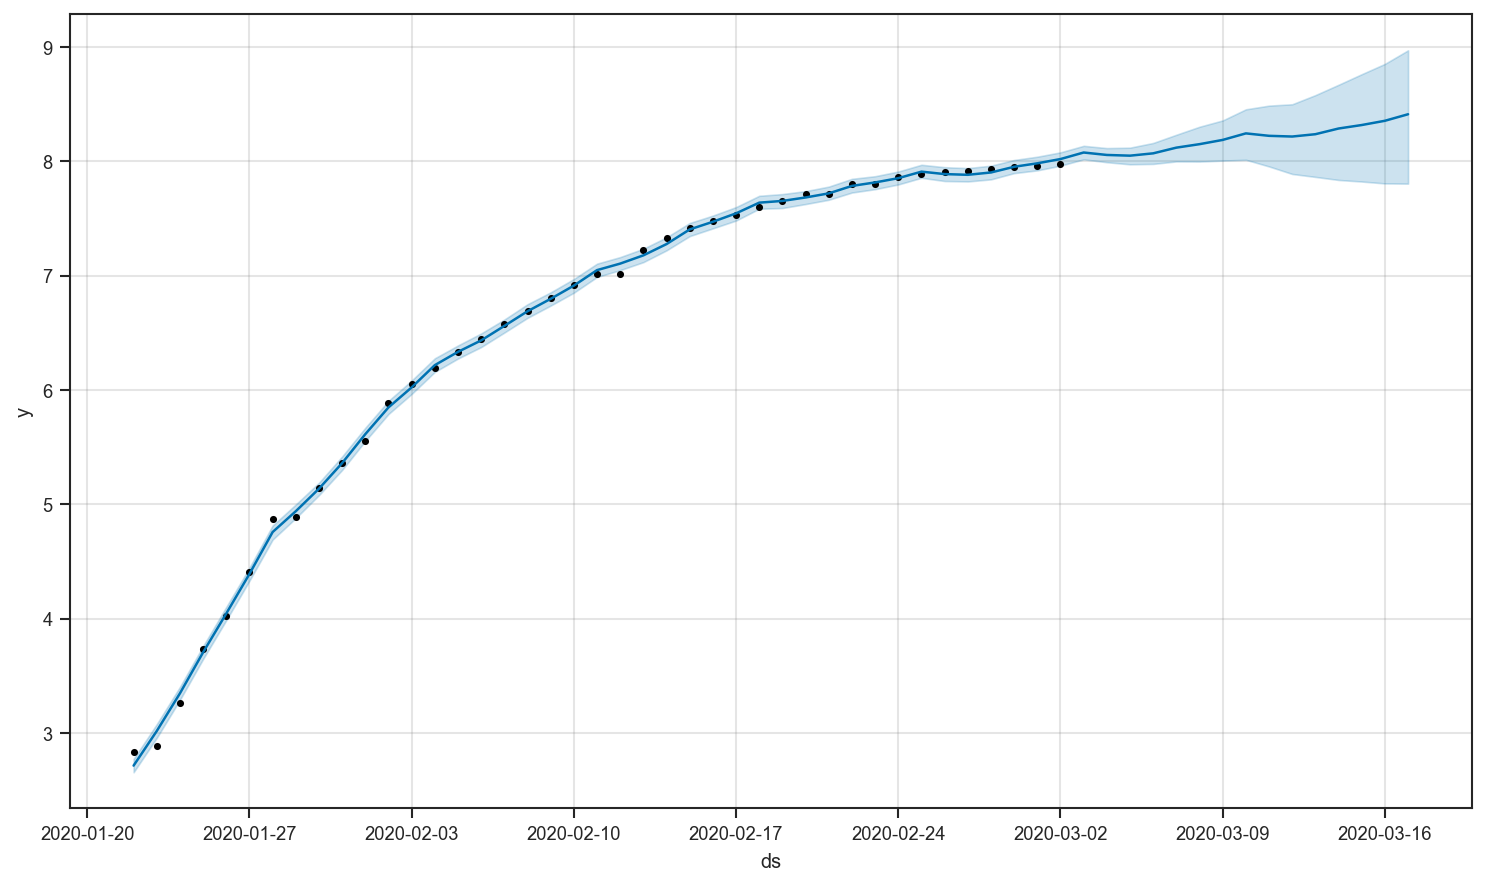

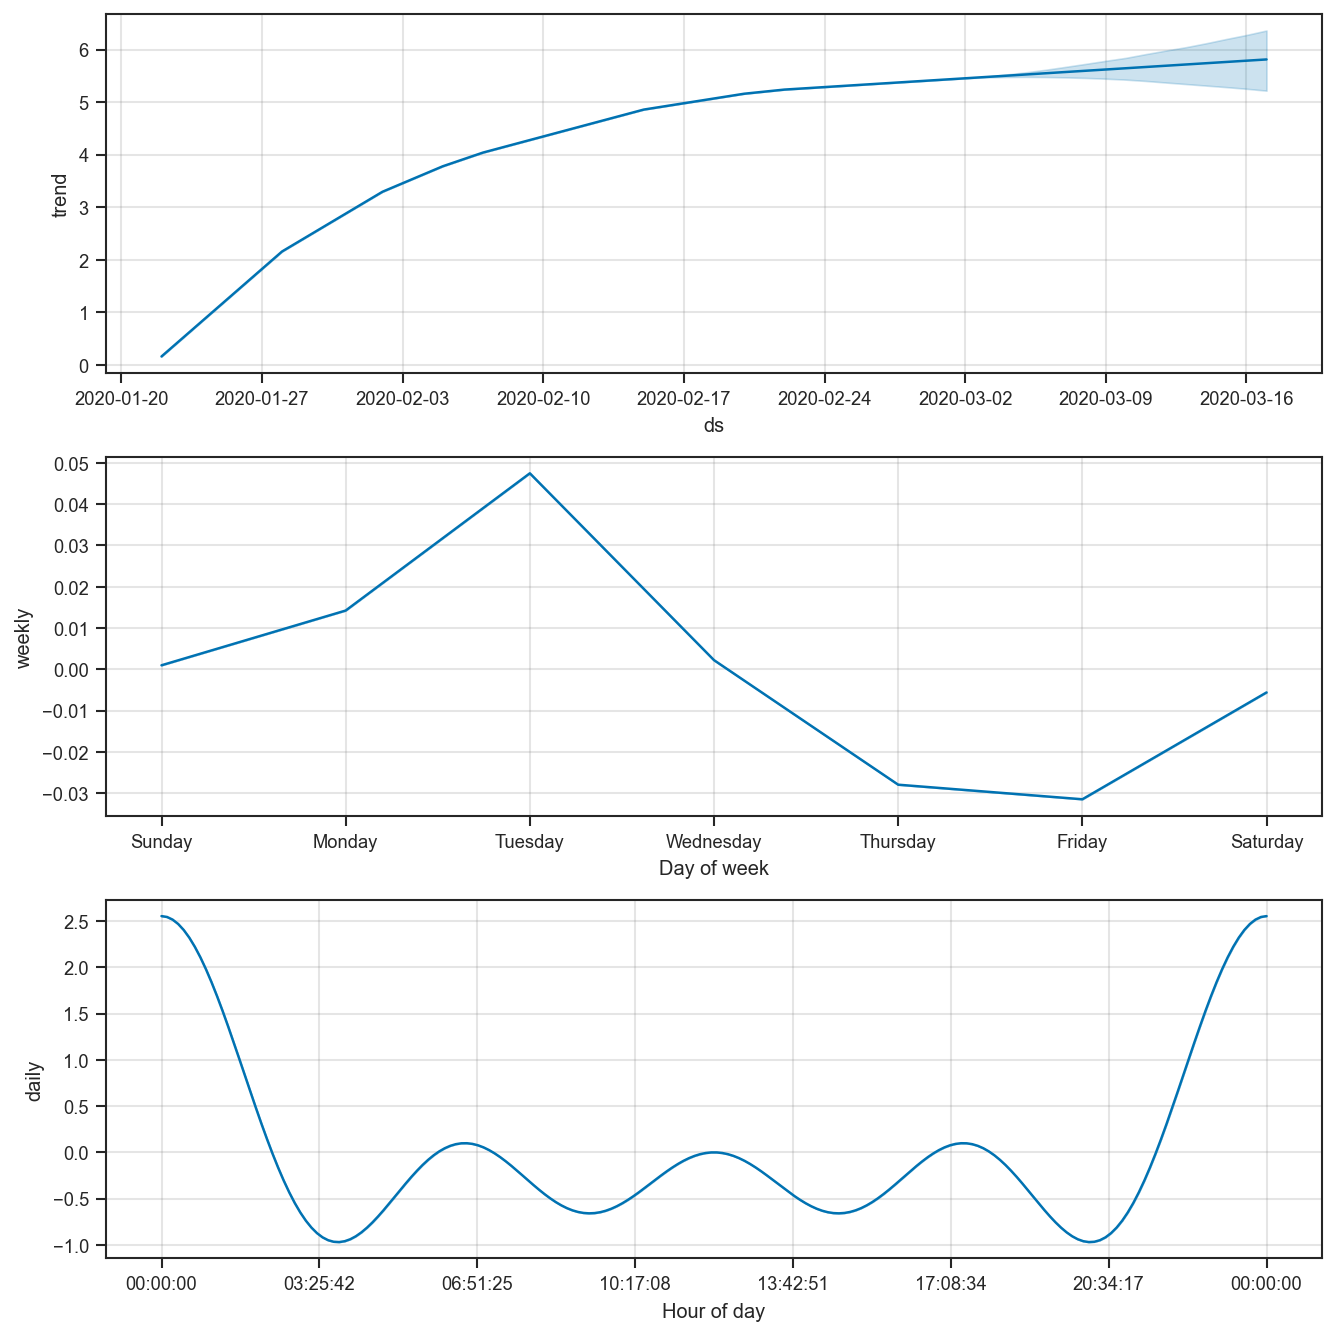

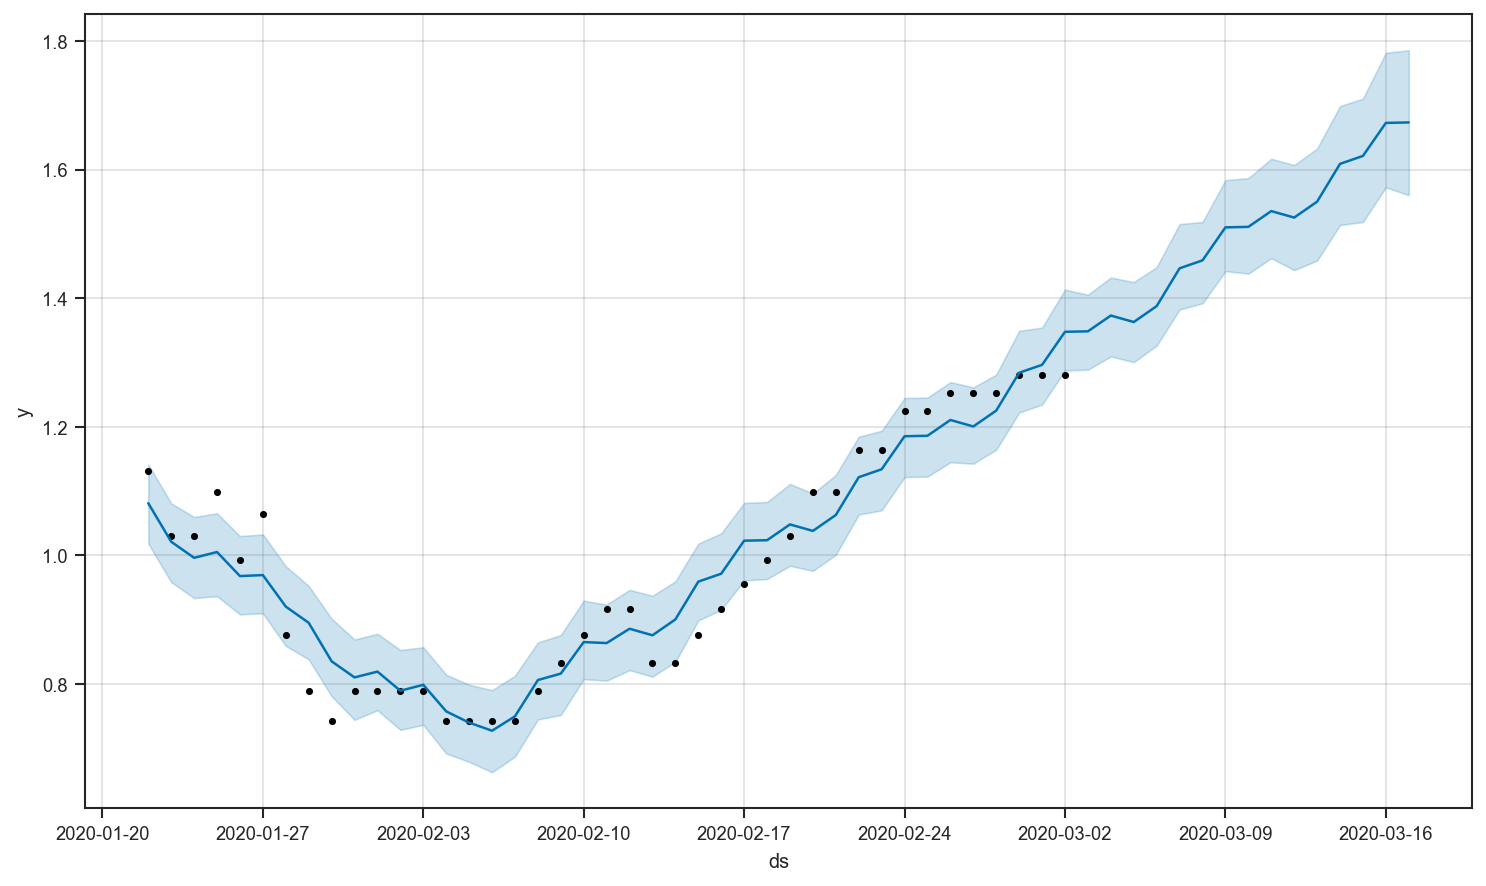

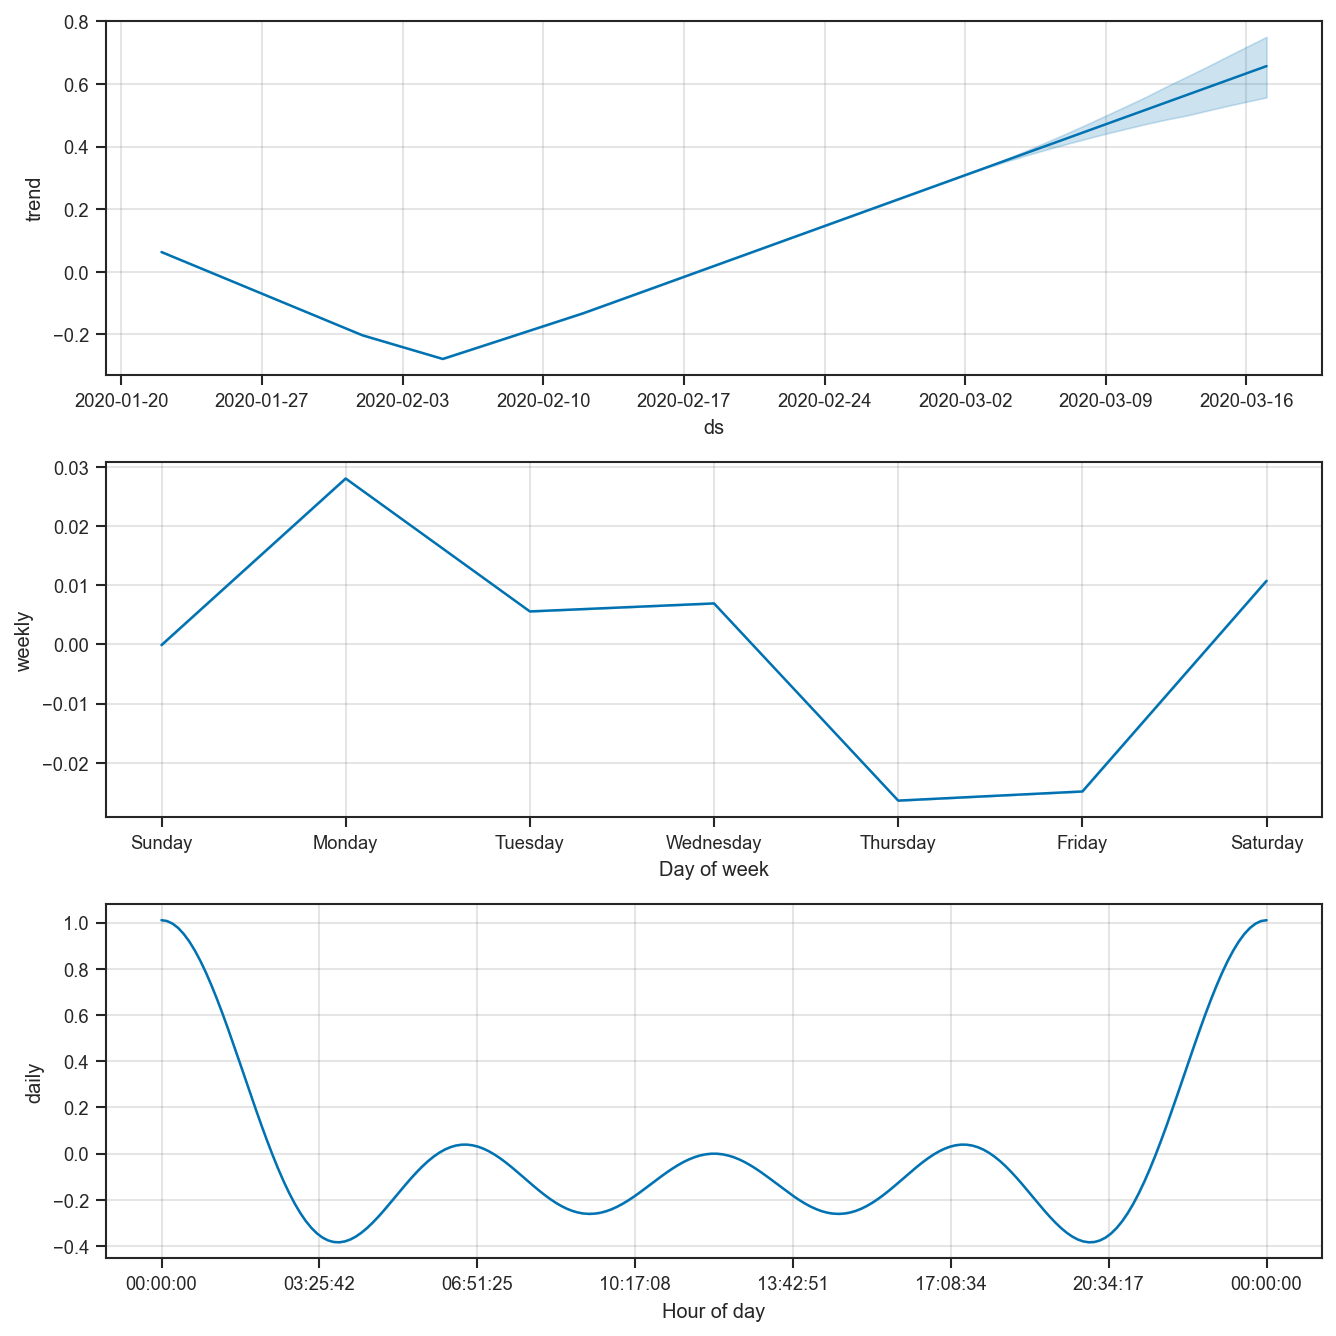

In [48]:
graph_prediction(df, 'China', 'Confirmed')
graph_prediction(df, 'China', 'Deaths')
graph_prediction(df, 'China', 'Deaths/Confirmed')

16:41:20 - cmdstanpy - INFO - Chain [1] start processing
16:41:20 - cmdstanpy - INFO - Chain [1] done processing


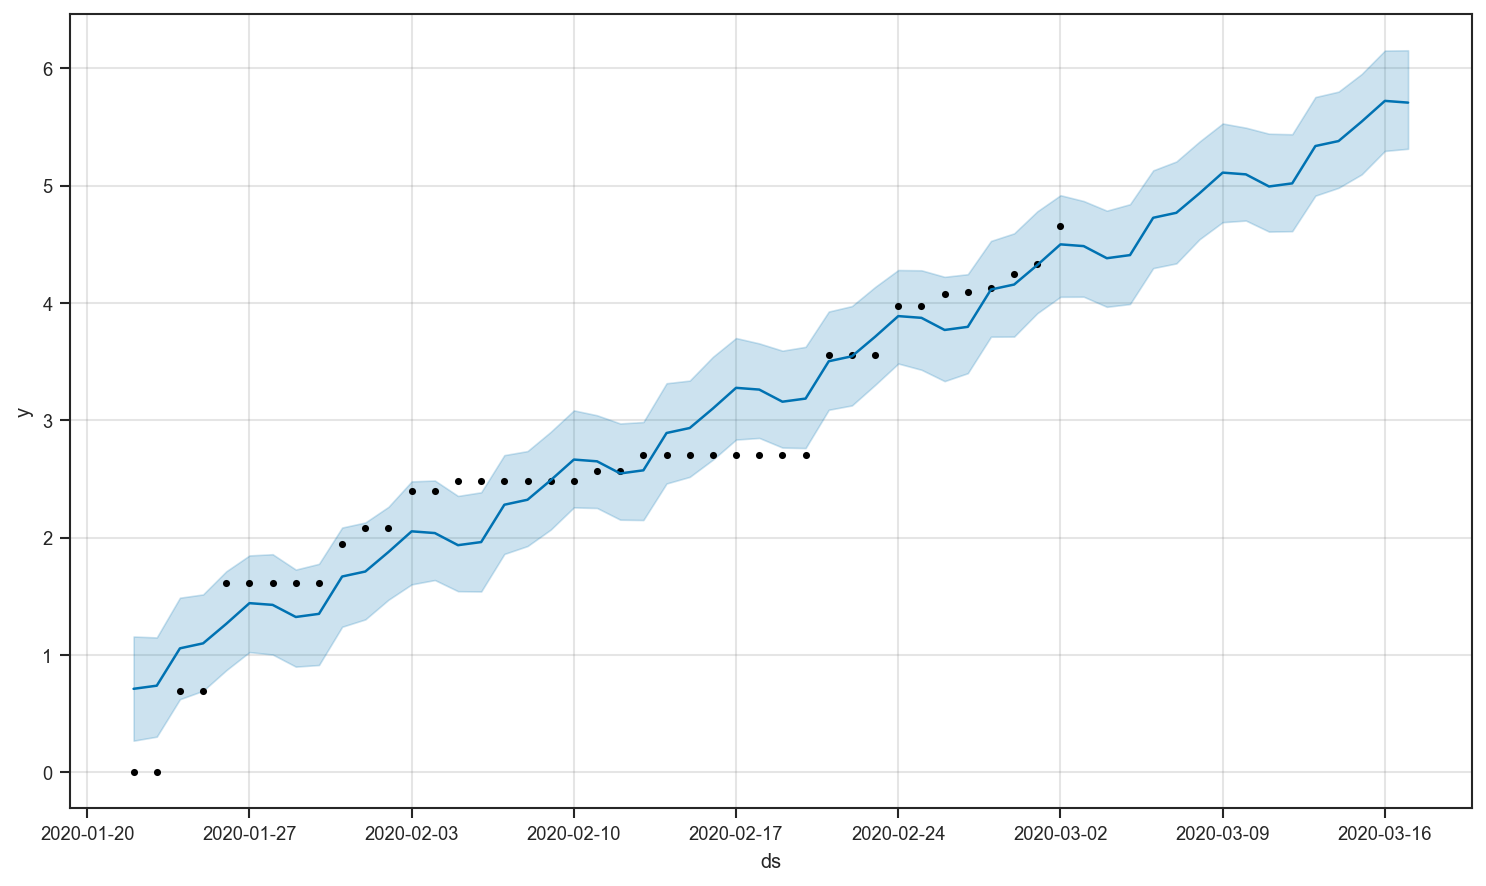

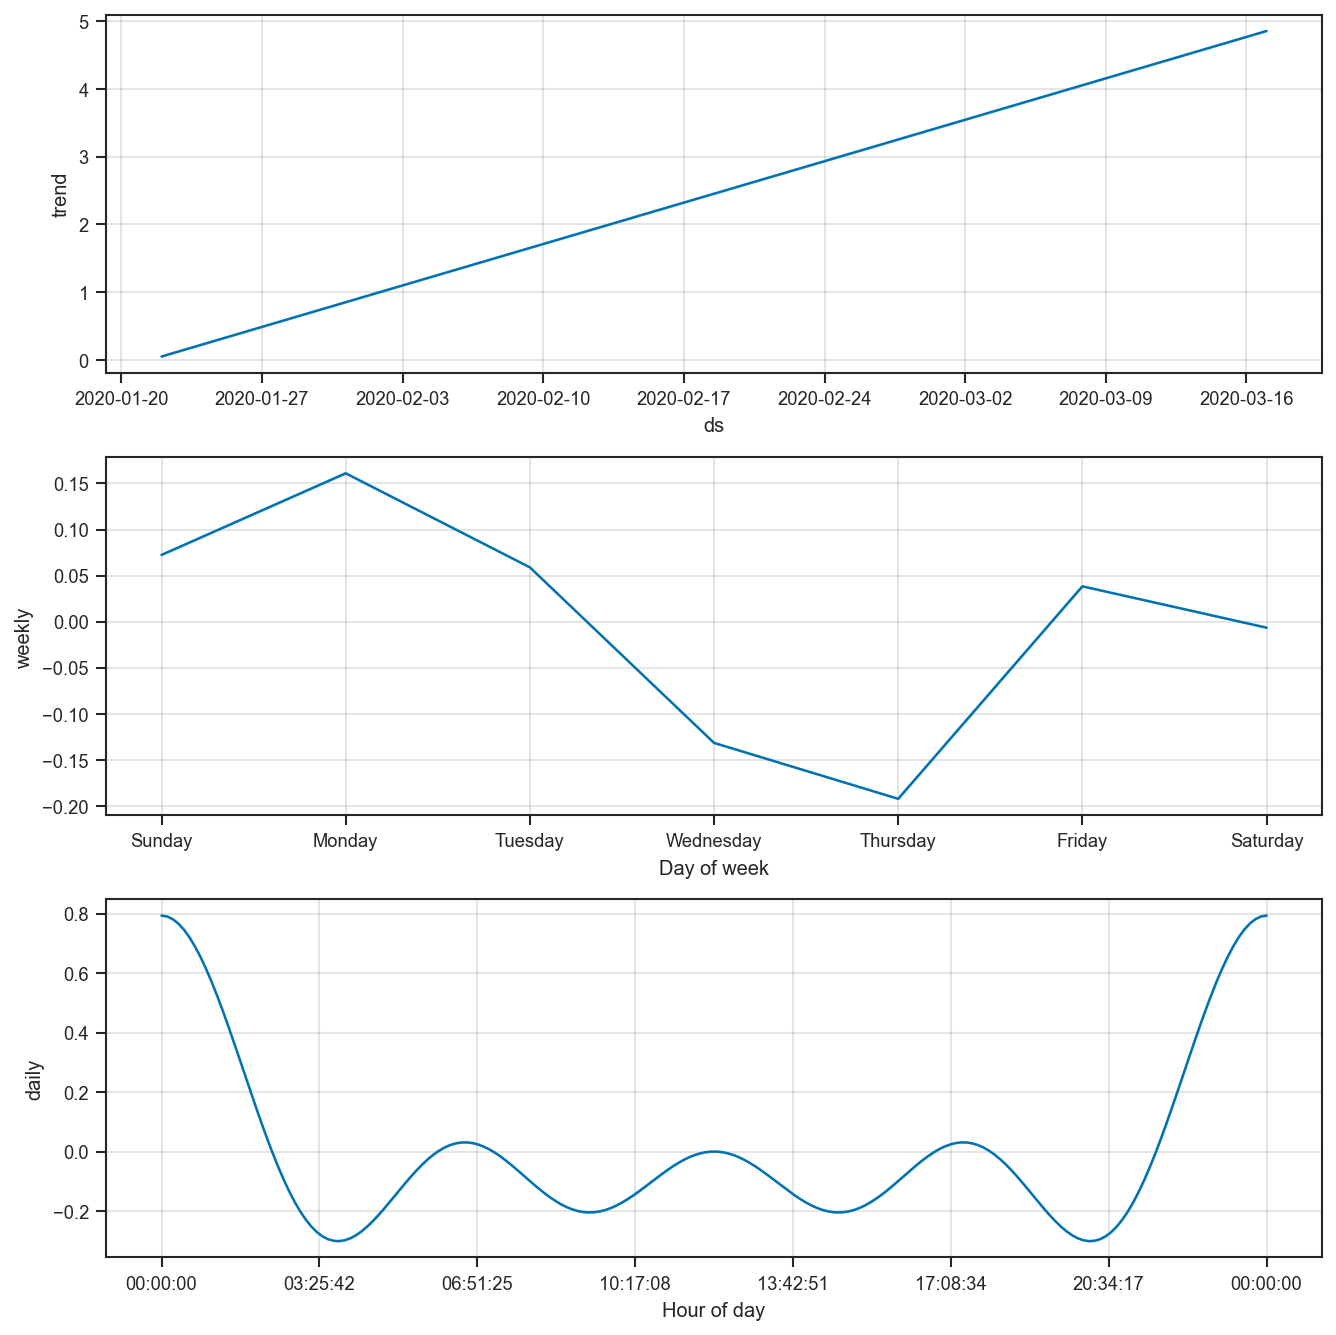

In [49]:
graph_prediction(df, 'US', 'Confirmed')

In [50]:
graph_prediction(df, 'US', 'Deaths')


[INFO] Forecast Calculation not possible
